In [1]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using LinearAlgebra
using DoubleFloats

Solving Stokes equations using Local Hermitian Interpolation with Div-free Polyharmonic kernel with polynomial reproductuion 
Key takeaways:
- It is not proven that div-free matrix kernel formed with polyharmonic RBF is conditionally positive definite, and if it is, which degree of conditionaly positive definitness it has 
- From numerical experiments it seems like it is indeed positive definite even without additional ponynomial basis, but it might be a lucky special case. I assume that matrix kernel formed by polyharmonics retains the same degree of c-pos-def as scalar polyharmonic function that creates it.
- Polynomial basis has to satisfy 2 properties: velocity subspace has to be div-free. pressure subspace can't contain constnt functions, otherwise matrices are degenerate. 
- Local stensil has to have enough points, such that it is m-unisolvent. Higher polynomial degree requires more points in the stencil, oterwise doesn't work. It is somewhat similar to a limit on the accuracy for a given stencil size in classical finite differences. 
- for the same separation distance, polyharmonic div-free kernel has considerably lower kondition number than anything else 
- If a true solution is a polynomial of a degree lower than the degree of the basis, the method recovers the solution with machine precision.

In [44]:
# create functionals
μ = 0.00025
ρ = 1
@variables ϵ r x₁ x₂ ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]
display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_A)
F_A = compile_kernel_array(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_B)
F_B = compile_kernel_array(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
F_PA = compile_polynomials(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials(F_PB)

N_poly = size(F_PA)[2]

println("done")

3×3 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                                    0     sqrt(x₁^2 + x₂^2)^3

6×6 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                                    …                                   (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                                       (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₁^2)*(sqrt(x₁^2 + x₂^2)^3)
                                                                    0.035(sqrt(x₁^2 + x₂^2)^3) + 0.02625(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.02625(x₁^2)*sqrt(x₁^2 + x₂^2) + 0.18375(x₂^2)*sqrt(x₁^2 + x₂^2) + 0.02625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)                                                                       -0.02625x₁*(x₂^3)*(sqrt

2×6 Matrix{Num}:
  0.035(sqrt(x₁^2 + x₂^2)^3) + 0.02625(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.02625(x₁^2)*sqrt(x₁^2 + x₂^2) + 0.18375(x₂^2)*sqrt(x₁^2 + x₂^2) + 0.02625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)  …  -0.02625x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 0.1575x₁*x₂*sqrt(x₁^2 + x₂^2) - 0.02625x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)
 -0.02625x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 0.1575x₁*x₂*sqrt(x₁^2 + x₂^2) - 0.02625x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)                                                                        0.035(sqrt(x₁^2 + x₂^2)^3) + 0.02625(x₁^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.02625(x₂^2)*sqrt(x₁^2 + x₂^2) + 0.18375(x₁^2)*sqrt(x₁^2 + x₂^2) + 0.02625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)

25-element Vector{Any}:
 Num[1, 0.0, 0.0]
 Num[x₂, 0.0, 0.0]
 Num[x₁, -x₂, 0.0]
 Num[x₂^2, 0.0, 0.0]
 Num[x₁*x₂, (-1//2)*(x₂^2), 0.0]
 Num[x₁^2, -2x₁*x₂, 0.0]
 Num[x₂^3, 0.0, 0.0]
 Num[x₁*(x₂^2), (-1//3)*(x₂^3), 0.0]
 Num[x₂*(x₁^2), -x₁*(x₂^2), 0.0]
 Num[x₁^3, -3x₂*(x₁^2), 0.0]
 Num[x₂^4, 0.0, 0.0]
 Num[x₁*(x₂^3), (-1//4)*(x₂^4), 0.0]
 Num[(x₁^2)*(x₂^2), (-2//3)*x₁*(x₂^3), 0.0]
 Num[x₂*(x₁^3), (-3//2)*(x₁^2)*(x₂^2), 0.0]
 Num[x₁^4, -4x₂*(x₁^3), 0.0]
 Num[0, 1, 0.0]
 Num[0, x₁, 0.0]
 Num[0, x₁^2, 0.0]
 Num[0, x₁^3, 0.0]
 Num[0, x₁^4, 0.0]
 Num[0.0, 0.0, x₂]
 Num[0.0, 0.0, x₁]
 Num[0.0, 0.0, x₂^2]
 Num[0.0, 0.0, x₁*x₂]
 Num[0.0, 0.0, x₁^2]

6×25 Matrix{Num}:
 1    x₂     x₁    x₂^2       …  0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0        0.0  0.0    0.0   0.0    0.0
 0.0   0.0    0.0    -0.0005     0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0        1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2          0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0     …  0.0  0.0    0.0   0.0    0.0

2×25 Matrix{Num}:
 0.0  0.0  0.0  -0.0005  0.0      -0.0005  …  0.0  1.0    0.0  x₂  2x₁
 0.0  0.0  0.0   0.0     0.00025   0.0        1.0  0.0  2x₂    x₁    0.0

done


In [45]:
# create true solution
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#= u = 20*x*y^3
v = 5*x^4 - 5*y^4
p = 60*x*x*y - 20*y*y*y =#
display(dx(u)+dy(v))
f1 = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
f2 = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
true_v1 = eval(build_function(u,x,y))
true_v2 = eval(build_function(v,x,y))
f1(12,2)
function gu(x,y)
    """
    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
    """
    return -y*sin(x^2 + y^2)
end
gv(x,y) = x*sin(x^2 + y^2)
gu(0.9,1)

0

0.002y*cos(x^2 + y^2) + cos(x - y) - 0.001(y^3)*sin(x^2 + y^2) - 0.001y*(x^2)*sin(x^2 + y^2)

0.001(x^3)*sin(x^2 + y^2) + 0.001x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 0.002x*cos(x^2 + y^2)

-0.9715269558223153

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]


2×156 Matrix{Float64}:
 0.0  0.0       0.0        0.0        …  1.0       1.0       1.0       1.0
 0.0  0.025641  0.0512821  0.0769231     0.923077  0.948718  0.974359  1.0

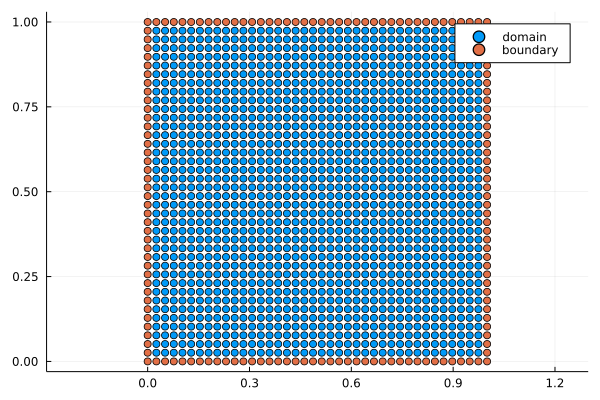

In [46]:
# create points 
N_side = 40
I_points, B_points = generate_2D_equally_spaced_points(N_side)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
#B_points = B_points[:, setdiff(1:end,[1,N_side,4*N_side-4,3*N_side-3])]
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [48]:
# assemble matrices and rhs 
k = 30
param = 5
r = 2.01*1.45/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
G = zeros(2*N_I,2*N_I) # global sprse matrix 
#Global_RHS = zeros(2*N_I)
Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
cond_num_array = zeros(N_I)
for i in 1:N_I
    #I_idx = inrange(I_tree, I_points[:,i], r, true)
    I_idx, _ = knn(I_tree, I_points[:,i], k, true)
    I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))

    B_idx = inrange(B_tree, I_points[:,i], r, true)
    Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
    Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
    #display(Local_I_points)
    Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
    #display(Full_Local_I_points)
    default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
    sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
    #sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
    L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
    if isempty(B_idx)
        # No boundary points nearby
        #T = point_difference_tensor(Points,Points)
        PA = generate_P_matrix(default_point_list,F_PA[1:end-2,:])
        
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
        B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
        RHS = vcat(L_RHS,zeros(N_poly))
        #display(A)
    else
        append!(default_point_list,[Local_B_points,Local_B_points])
        PA = generate_P_matrix(default_point_list,F_PA[1:end,:])
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A,T,param))
        B = flatten(generate_block_matrices(F_B,T2,param))
        
        #RHS = vcat(L_RHS,true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx])
        #,zeros(N_poly))
        RHS = vcat(L_RHS,gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx])
        ,zeros(N_poly))

    end
    O = zeros(N_poly,N_poly)
    #display(A)
    cond_num_array[i] = cond([A PA;PA' O])
    PB = generate_P_matrix(sample_point_list,F_PB)
    N_I_local = length(I_idx)+1 # total number of local internal points counting the center
    #A = Double64.(A)
    C = [B PB]*inv(([A PA;PA' O]))
    #C = B*inv(A)
    #display([A PA;PA' O])
    #C = Float64.(C)
    #println([i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I))
    #display(C[:,1:2*N_I_local])
    G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]
    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 
    #display(maximum(abs.(inv(A)*A .- Matrix(I(size(A)[1])))))
    
    
    #println(i,"  ",I_idx)
end
println("max local cond number: ",maximum(cond_num_array))
#println("global condition number: ",cond(Matrix(G)))
#display(Global_RHS)
display(length(sparse(G).nzval)/(4*N_I^2))

max local cond number: 2.543572454594191e9


0.02077562326869806

[-3.371600033139462e-5, -0.0001685797466127312, -0.000505736507226986, -0.0011463204744616758, -0.0021914339246288106, -0.0037421080186339703, -0.005899239130700222, -0.008763494605713816, -0.012435181869462035, -0.017014074856105555, -0.022599191779826017, -0.029288518369989257, -0.037178670819638826, -0.04636449287491851, -0.0569385817282744, -0.06899073768202418, -0.08260733293290101, -0.09787059530495769, -0.11485780334078036, -0.13364038986272328, -0.15428295195044794, -0.17684216626200372, -0.20136560976628617, -0.22789048726757183, -0.2564422685995845, -0.28703324005738395, -0.3196609765285745, -0.35430674288675945, -0.390933835522648, -0.42948587741092203, -0.4698850828387089, -0.5120305108440243, -0.5557963295137385, -0.6010301165477374, -0.6475512248788045, -0.6951492456079486, -0.7435826040250059, -0.7925773279772667, -8.42898733063656e-5, -0.00026972683673560536, -0.0006574541912022488, -0.0013486015383219836, -0.0024442626292712276, -0.004045454854905408, -0.00625305426577

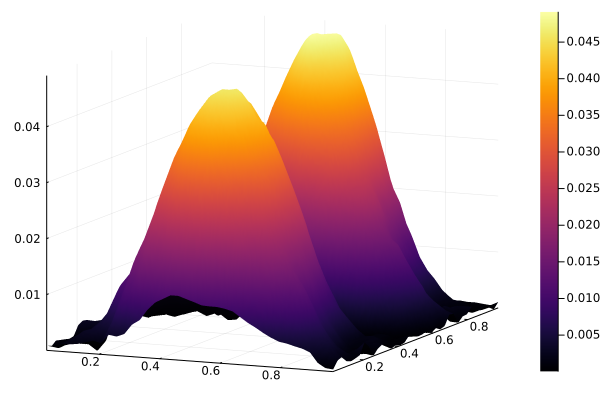

In [49]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
G = sparse(G)
println(reference_v)
sol = G\Global_RHS
error = abs.(sol - reference_v)
println("max error: ",maximum(error))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],error[1:N_I])

(2, 1444)0.025641025641025640.025641025641025640.025641025641025640.051282051282051280.025641025641025640.076923076923076930.025641025641025640.102564102564102560.025641025641025640.12820512820512820.025641025641025640.153846153846153850.025641025641025640.17948717948717950.025641025641025640.205128205128205120.025641025641025640.230769230769230780.025641025641025640.25641025641025640.025641025641025640.282051282051282050.025641025641025640.30769230769230770.025641025641025640.33333333333333330.025641025641025640.3589743589743590.025641025641025640.384615384615384640.025641025641025640.410256410256410240.025641025641025640.43589743589743590.025641025641025640.461538461538461560.025641025641025640.487179487179487170.025641025641025640.51282051282051280.025641025641025640.53846153846153840.025641025641025640.56410256410256410.025641025641025640.58974358974358980.025641025641025640.61538461538461540.025641025641025640.64102564102564110.025641025641025640.66666666666666660.0256410256410256

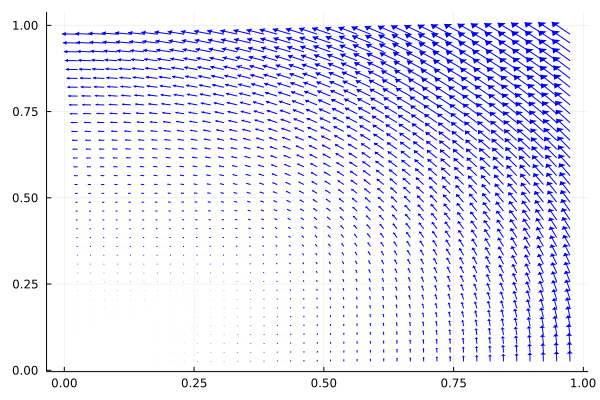

In [50]:
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end


visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])